# Kodowanie Huffmana
Jakub Karbowski

In [1]:
import Pkg
Pkg.add([
    "BenchmarkTools",
    "Plots",
    "GraphRecipes",
])

using BenchmarkTools: BenchmarkTools, @belapsed
import Plots: plot
using GraphRecipes: graphplot
using Serialization: serialize, deserialize

BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1
;

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


# Algorytm statyczny

data = "abracadabra"


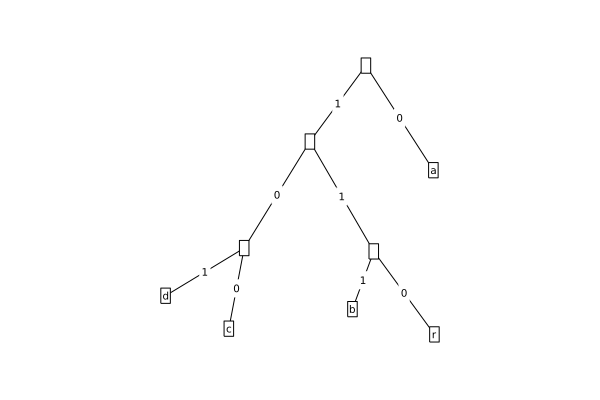

Dict{Char, BitVector} with 5 entries:
  'a' => [0]
  'c' => [1, 0, 0]
  'd' => [1, 0, 1]
  'r' => [1, 1, 0]
  'b' => [1, 1, 1]

compressed = Bool[0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0]
decompressed = "abracadabra"


In [2]:
struct Huffman{T}
    code::Dict{T, BitVector}
    root::Any
end

Huffman(text::T) where T<:AbstractString = Huffman(Vector{Char}(text))

function Huffman(text::V) where {T, V<:AbstractVector{T}}
    if length(text) < 2
        throw("Text too short")
    end
    
    counts = Dict{T, Int}()
    for c = text
        get!(counts, c, 0)
        counts[c] += 1
    end
    
    internal = []
    leafs = sort([(k,v) for (k,v)=counts], by=(x -> x[2]))
    
    function getlowestcost!()
        if isempty(internal)
            popfirst!(leafs)
        elseif isempty(leafs)
            popfirst!(internal)
        elseif internal[1][2] < leafs[1][2]
            popfirst!(internal)
        else
            popfirst!(leafs)
        end
    end
    
    while length(leafs) + length(internal) > 1
        el1, el2 = getlowestcost!(), getlowestcost!()
        push!(internal, ((el1[1], el2[1]), el1[2] + el2[2]))
    end
    
    root = internal[1][1]

    code = Dict{T, BitVector}()
    
    function makecode(s::U, c::BitVector) where U<:Tuple
        makecode(s[1], [c; false])
        makecode(s[2], [c; true])
    end
    
    function makecode(s::T, c::BitVector)
        code[s] = c
    end
    
    makecode(root, BitVector())
    
    Huffman(code, root)
end

function plot(h::Huffman{T}) where T
    nverts = 0
    edges = []
    vlabels = Dict{Int, String}()
    elabels = Dict{Tuple{Int, Int}, String}()
    
    function process(symb::T)
        nverts += 1
        vlabels[nverts] = "$symb"
        nverts
    end
    
    function process(symb)
        left = process(symb[1])
        right = process(symb[2])
        
        nverts += 1
        this = nverts
        vlabels[this] = " "

        push!(edges, (this, left))
        elabels[this, left] = "0"
        
        push!(edges, (this, right))
        elabels[this, right] = "1"
        
        this
    end
    
    process(h.root)
    
    G = falses(nverts, nverts)
    for (u, v) = edges
        G[u, v] = true
    end
    
    graphplot(G,
        names=vlabels,
        edgelabel=elabels,
        curves=false,
        method=:tree,
        nodeshape=:rect,
        nodecolor=:white,
    )
end

compress(text::T, h::Huffman{Char}) where T<:AbstractString = compress(Vector{Char}(text), h)

function compress(data::V, h::Huffman{T}) where {T, V<:AbstractVector{T}}
    code = h.code
    output = BitVector()
    for symb = data
        append!(output, code[symb])
    end
    output
end

decompress(data::BitVector, h::Huffman{Char}) = _decompress(data, h) |> String
decompress(data::BitVector, h::Huffman) = _decompress(data, h)

function _decompress(data::BitVector, h::Huffman{T}) where T
    root = h.root
    state = root
    output = Vector{T}()
    for bit = data
        state = bit ? state[2] : state[1]
        if typeof(state) == T
            push!(output, state)
            state = root
        end
    end
    output
end

data = "abracadabra"
@show data

h = Huffman(data)
display(plot(h))

display(h.code)

compressed = compress(data, h)
@show compressed

decompressed = decompress(compressed, h)
@show decompressed
;

Algorytm buduje poprawny kod.
Tekst jest kompresowany oraz dekompresowany.

# Ostatni zajazd na Litwie

In [5]:
data = read("data/tadeusz")
h = Huffman(data)
compressed = compress(data, h)
decompressed = decompress(compressed, h)
@show data == decompressed
println("Compression factor: $(round(100 - 100length(compressed) / 8length(data), digits=2))%")

data == decompressed = true
Compression factor: 36.14%


Cały Pan Tadeusz został skompresowany o 36%.
Nie uwzględnia to miejsca na sam kod.
Udało się również odtworzyć oryginał na podstawie
zakodowanej postaci.

# Pliki
Korzystam z wbudowanej funkcji `serialize` oraz `deserialize`
aby zapisać kod oraz dane do pliku.

In [8]:
function compressfile(fin, fout)
    data = read(fin)
    h = Huffman(data)
    compressed = compress(data, h)
    serialize(fout, (h.root, compressed))
end

function decompressfile(fin, fout)
    root, compressed = deserialize(fin)
    data = decompress(compressed, Huffman(Dict{UInt8, BitVector}(), root))
    open(fout, "w") do f
        write(f, data)
    end
end

compressfile("data/tadeusz", "data/tadeusz.hf")
decompressfile("data/tadeusz.hf", "data/tadeusz.decomp")

@show read("data/tadeusz") == read("data/tadeusz.decomp")

f = 1 - length(read("data/tadeusz.hf")) / length(read("data/tadeusz"))
println("Compression factor: $(round(100f, digits=2))%")

read("data/tadeusz") == read("data/tadeusz.decomp") = true
Compression factor: 36.05%


Program kompresuje/dekompresuje poprawnie.
Poziom kompresji zmniejszył się nieznacznie ze
względu na dodanie kodu do pliku.
Jak widać, funkcja `serialize` wydajnie zapisuje
dane do pliku.

# Testy
Testowane pliki to programy w języku C.
Wykorzystano plik o rozmiarze 86 KB będący
kompilacją różnych programów w C.
Następnie plik powielano lub obcinano aby uzyskać wszystkie
potrzebne rozmiary: 1K, 10K, 100K, 1M.

In [9]:
function test(name)
    println("File: $name")
    tc = @belapsed compressfile($name, $("$name.hf"))
    td = @belapsed decompressfile($("$name.hf"), $("$name.decomp"))
    println("Compression time:   $(round(1000tc, digits=2)) ms")
    println("Decompression time: $(round(1000td, digits=2)) ms")
    factor = 1 - length(read("$name.hf")) / length(read(name))
    println("Compression factor: $(round(100factor, digits=2))%")
end

test("data/1K")
test("data/10K")
test("data/100K")
test("data/1M")

File: data/1K
Compression time:   0.34 ms
Decompression time: 1.38 ms
Compression factor: 4.49%
File: data/10K
Compression time:   0.82 ms
Decompression time: 14.3 ms
Compression factor: 25.97%
File: data/100K
Compression time:   4.43 ms
Decompression time: 129.77 ms
Compression factor: 33.9%
File: data/1M
Compression time:   39.64 ms
Decompression time: 1333.86 ms
Compression factor: 34.27%


## Skuteczność kompresji
Dla 1 KB kompresja jest mało wydajna.
Jest tak, ponieważ rozmiar kodu będzie miał znaczny
wpływ na rozmiar całego pliku.
Można uznać, że funkcja `serialize` nie jest optymalna
i można lepiej przechowywać dane.
W takich plikach najczęstszym znakiem jest znak nowej linii.
W krótkim pliku będzie ich mało, co również wpływa
na mały poziom kompresji.

Plik 10 KB kompresuje się dobrze.
Rozmiar kodu jest mały w porównaniu z całym plikiem.

Dla większych plików uzyskujemy wyniki
jak dla Pana Tadeusza.

## Czas kompresji
Dla małych plików czas samej kompresji jest porównywalny
z czasem załadowania pliku i różnym przetwarzaniem nie związanym
z samą kompresją.

Dla większych plików widzimy zależność liniową.

Czas dekompresji również ma zależność liniową.

Czas dekompresji jest większy od czasu kompresji.
Jest tak prawdopodobnie ze względu na nieoptymalną
implementację.